In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

# TorchVision Instance Segmentation Finetuning Tutorial

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [2]:
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-jxjuhahi
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-jxjuhahi
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

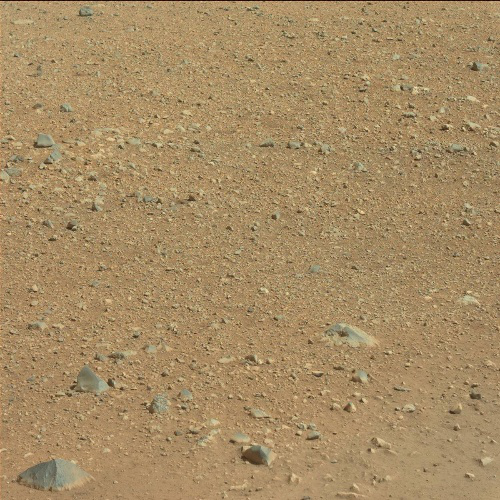

In [3]:
from PIL import Image
img_num = "013"
dataset_path = '../m_rocks_dataset/'
Image.open(f'{dataset_path}images/{img_num}.png')

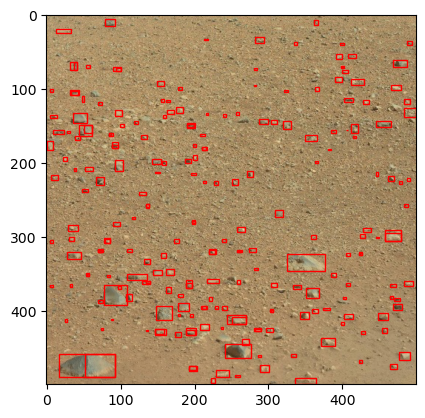

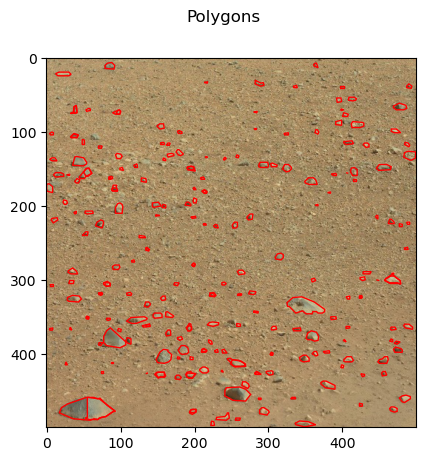

<Figure size 640x480 with 0 Axes>

In [4]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Open the labels
label_path = f'{dataset_path}labels/{img_num}.json'
with open(label_path) as json_file:
    labels = json.load(json_file)

# Open the image
image = Image.open(f'{dataset_path}images/{img_num}.png')

# Create figure and axes for polygons
fig_polygons, ax_polygons = plt.subplots(1)
ax_polygons.imshow(image)

# Create figure and axes for bounding boxes
fig_bboxes, ax_bboxes = plt.subplots(1)
ax_bboxes.imshow(image)

# Loop through each polygon
for polygon in labels["polygons"]:
    polygon = np.array(polygon).reshape(-1,2) # reshape each polygon to have a shape (n, 2)
    ax_polygons.add_patch(patches.Polygon(polygon, linewidth=1, edgecolor='r', facecolor='none'))

# Loop through each bounding box
for bbox in labels["bboxes"]:
    # Note that bbox contains [x, y, width, height]
    bbox = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax_bboxes.add_patch(bbox)

# Display polygons
fig_polygons.suptitle('Polygons')
plt.figure(fig_polygons.number)
plt.show()

# Display bounding boxes
fig_bboxes.suptitle('Bounding Boxes')
plt.figure(fig_bboxes.number)
plt.show()


So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [5]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import cv2

class RocksDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.labels = list(sorted(os.listdir(os.path.join(root, "labels"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        label_path = os.path.join(self.root, "labels", self.labels[idx])
        img = Image.open(img_path).convert("RGB")
        image_np = np.array(img)
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        with open(label_path) as json_file:
            label = json.load(json_file)

        # get boxes in x1, y1, x2, y2 format from xywh
        boxes = []
        for box in label['bboxes']:
            x1 = box[0]
            y1 = box[1]
            x2 = x1 + box[2]
            y2 = y1 + box[3]

            xmin = min(x1, x2)
            xmax = max (x1, x2)
            ymin = min(y1, y2)
            ymax = max(y1, y2)

            if box[2] == 0 or box[3] == 0:
                continue
            boxes.append([xmin, ymin, xmax, ymax])
        
        # generate masks from the polygons
        masks = []

        # Loop through each polygon
        for polygon in label["polygons"]:
            # Create an array of zeros with the same shape as the original image
            mask = np.zeros(image_np.shape[:2], dtype=np.uint8)  # create a 2D mask, same size as the image
            polygon = np.array(polygon, np.int32).reshape((-1, 1, 2))  # reshape to fit the input format of fillPoly function
            cv2.fillPoly(mask, [polygon], 1)  # 255 for white color
            masks.append(mask)

        masks = np.stack(masks)

        # get bounding box coordinates for each mask
        num_objs = len(masks)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


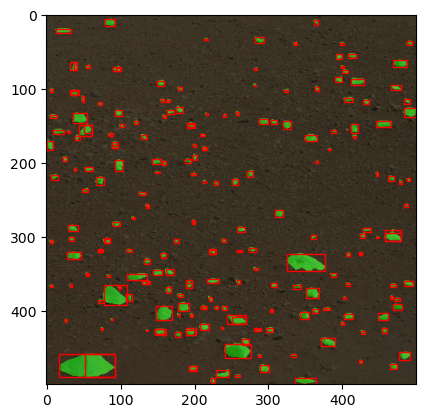

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import ImageEnhance

# Assuming that you've loaded the image and the boxes as you've indicated:
dataset = RocksDataset(dataset_path)
img, data = dataset[13]  # Assuming this returns a PIL Image
img_np = np.array(img)
boxes = data["boxes"].tolist()  # Assuming these are the bounding boxes
masks = data["masks"].numpy()  # Assuming these are the masks

# Darken the image
enhancer = ImageEnhance.Brightness(img)
img_darker = enhancer.enhance(0.7)  # Enhance by a factor of 0.7 to darken
img_np = np.array(img_darker)

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(img_np)

# Create a mask image with green color
green_mask = np.zeros((*masks.shape[1:], 3))  # Start with an all black image
for mask in masks:
    green_mask[mask == 1] = [0, 255, 0]  # Only color the pixels where the mask is present with green

# Overlay mask image, make mask semi-transparent
ax.imshow(green_mask, alpha=0.5)

# Add bounding boxes
for box in boxes:
    # Extract box coordinates
    xmin, ymin, xmax, ymax = box

    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An Instance segmentation model for PennFudan Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [7]:
# # Download TorchVision repo to use some files from
# # references/detection
# !git clone https://github.com/pytorch/vision.git
# !cd vision
# !git checkout v0.8.2

# !cp references/detection/utils.py ../
# !cp references/detection/transforms.py ../
# !cp references/detection/coco_eval.py ../
# !cp references/detection/engine.py ../
# !cp references/detection/coco_utils.py ../



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [8]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = RocksDataset(dataset_path, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

/home/sastrong/miniconda3/envs/sam_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sastrong/miniconda3/envs/sam_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [11]:
# use our dataset and defined transformations
dataset = RocksDataset(dataset_path, get_transform(train=True))
dataset_test = RocksDataset(dataset_path, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and rock
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.5)

/home/sastrong/miniconda3/envs/sam_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [13]:
# let's train it for 20 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/27]  eta: 0:01:10  lr: 0.000020  loss: 12.4104 (12.4104)  loss_classifier: 0.6171 (0.6171)  loss_box_reg: 0.6382 (0.6382)  loss_mask: 2.0947 (2.0947)  loss_objectness: 8.1854 (8.1854)  loss_rpn_box_reg: 0.8751 (0.8751)  time: 2.6270  data: 0.7103  max mem: 2686
Epoch: [0]  [10/27]  eta: 0:00:08  lr: 0.000212  loss: 7.7932 (7.5950)  loss_classifier: 0.6138 (0.6133)  loss_box_reg: 0.4744 (0.4971)  loss_mask: 1.7412 (1.6192)  loss_objectness: 4.3863 (4.2664)  loss_rpn_box_reg: 0.5943 (0.5991)  time: 0.4720  data: 0.0924  max mem: 5345
Epoch: [0]  [20/27]  eta: 0:00:02  lr: 0.000404  loss: 3.3914 (5.4232)  loss_classifier: 0.5754 (0.5709)  loss_box_reg: 0.3928 (0.4357)  loss_mask: 1.0003 (1.2742)  loss_objectness: 1.0397 (2.6116)  loss_rpn_box_reg: 0.4548 (0.5308)  time: 0.2531  data: 0.0297  max mem: 5345
Epoch: [0]  [26/27]  eta: 0:00:00  lr: 0.000500  loss: 2.8770 (4.7581)  loss_classifier: 0.5184 (0.5474)  loss_box_reg: 0.3567 (0.4036)  loss_mask: 0.8638 (1.1477)  loss_

In [15]:
torch.save(model.state_dict(), "./weights/20e_mrcnn.pth")

Now that training has finished, let's have a look at what it actually predicts in a test image

In [1]:
# pick one image from the test set
img, _ = dataset_test[45]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

NameError: name 'dataset_test' is not defined

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

[{'boxes': tensor([[2.4188e+01, 2.5443e+01, 3.5854e+02, 3.6020e+02],
          [1.3707e+00, 1.7866e+02, 4.2150e+02, 4.3046e+02],
          [1.3423e+02, 6.0872e+01, 4.6850e+02, 3.9628e+02],
          [1.0883e+02, 6.8343e+01, 3.4837e+02, 4.9605e+02],
          [3.3753e+01, 1.0996e+02, 2.7292e+02, 4.9700e+02],
          [1.5412e+00, 6.5917e+00, 1.9889e+02, 4.2563e+02],
          [2.3404e+00, 2.6322e+00, 4.6330e+02, 2.4256e+02],
          [2.5910e+02, 7.5664e+01, 4.9811e+02, 4.9735e+02],
          [2.1041e+02, 2.4796e+00, 4.9798e+02, 2.8005e+02],
          [1.0875e+02, 2.5675e+02, 4.9693e+02, 4.9634e+02],
          [1.5531e+02, 9.6221e+01, 3.2311e+02, 2.6304e+02],
          [1.3936e+02, 1.8189e+02, 2.6201e+02, 4.2336e+02],
          [2.9325e+02, 1.1400e+02, 4.6567e+02, 2.8550e+02],
          [2.9427e+02, 2.3562e+02, 4.6373e+02, 4.0336e+02],
          [1.5389e+02, 2.1473e+02, 3.2382e+02, 3.8452e+02],
          [2.5869e+02, 1.0043e+02, 3.8059e+02, 3.4485e+02],
          [2.2145e+02, 3.1669e+

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

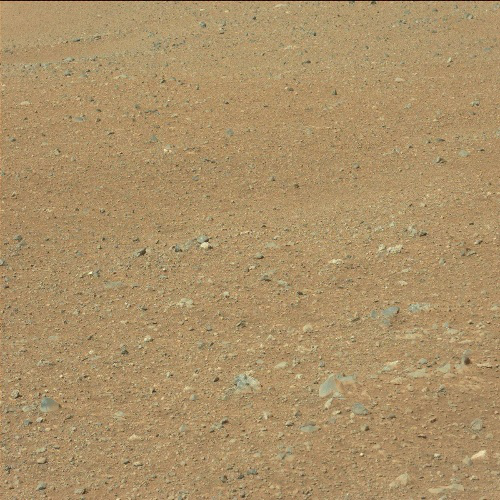

In [20]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

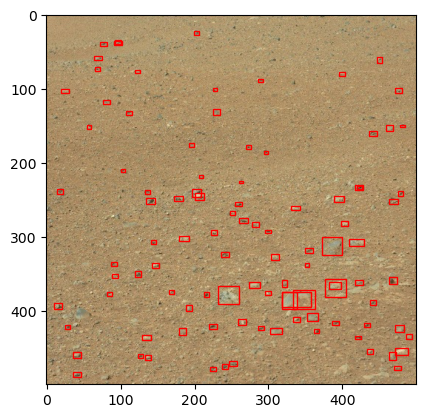

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

# Create a figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Get the box predictions
boxes = prediction[0]['boxes']

# Add bounding boxes
for box in boxes:
    # Extract box coordinates
    xmin, ymin, xmax, ymax = box.tolist()
    area = (xmax - xmin) * (ymax - ymin)

    # Create a rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')

    # Add the rectangle patch to the axes
    if (area < 8000):
        ax.add_patch(rect)

# Show the plot
plt.show()

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.8.2/references/detection).

